## Classification using Tensorflow

This workbook requires that you have downloaded the onehot.png from Moodle and put it in the same folder as the workbook.

We are going to try the digits data set - actually two different digits datasets and use Neural Networks to classify them.

Convolutional Neural Networks are the best thing around for images so that's done at the end of this workbook

Digits have 10 possible categories - mlpclassifier-example(2) was a binary classification system so slightly different.

I'm not spending much time trying to decide on the number of layers and units - I could use validation sets to try picking better ones but I just want to demonstrate to you some of the features of the library

In [523]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

Let's use sklearn's dataset first

In [524]:
from sklearn import datasets

In [525]:
digits = datasets.load_digits()

In [526]:
data = digits.images

In [527]:
digits.target

array([0, 1, 2, ..., 8, 9, 8])

So the targets are the numbers 
0,1,2,3,4,5,6,7,8,9

10 possible classes

In [528]:
from sklearn.model_selection import train_test_split

In [529]:
X_train, X_test, y_train, y_test = train_test_split(
    data, digits.target, test_size=0.2, random_state=42)

In [530]:
X_train

array([[[ 0.,  0.,  3., ...,  0.,  0.,  0.],
        [ 0.,  0., 12., ...,  0.,  0.,  0.],
        [ 0.,  3., 16., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  4., 16., ..., 15.,  2.,  0.],
        [ 0.,  1., 14., ..., 13., 11.,  0.],
        [ 0.,  0.,  3., ..., 13.,  4.,  0.]],

       [[ 0.,  0.,  9., ...,  0.,  0.,  0.],
        [ 0.,  0., 15., ..., 12.,  0.,  0.],
        [ 0.,  3., 10., ..., 12.,  5.,  0.],
        ...,
        [ 0.,  5.,  8., ..., 10.,  6.,  0.],
        [ 0.,  4., 13., ..., 13.,  0.,  0.],
        [ 0.,  0.,  6., ...,  3.,  0.,  0.]],

       [[ 0.,  0.,  0., ...,  3.,  0.,  0.],
        [ 0.,  0.,  8., ..., 12.,  0.,  0.],
        [ 0.,  3., 16., ..., 14.,  1.,  0.],
        ...,
        [ 0.,  2., 13., ..., 16.,  4.,  0.],
        [ 0.,  0., 10., ..., 14.,  1.,  0.],
        [ 0.,  0.,  2., ...,  6.,  0.,  0.]],

       ...,

       [[ 0.,  0.,  9., ..., 13.,  1.,  0.],
        [ 0.,  0., 12., ..., 16.,  7.,  0.],
        [ 0.,  0.,  0., ..., 16.,  4.,  0.

In [531]:
X_train.shape

(1437, 8, 8)

8 x 8 images, not very detailed but let's do it anyway

In [532]:
X_train.min()

np.float64(0.0)

In [533]:
X_train.max()

np.float64(16.0)

Greyscale, with min 0 and max 16. It doesn't even have 255 possibilities! It's a 4-bit image. 

But anyway, we can still do machine learning

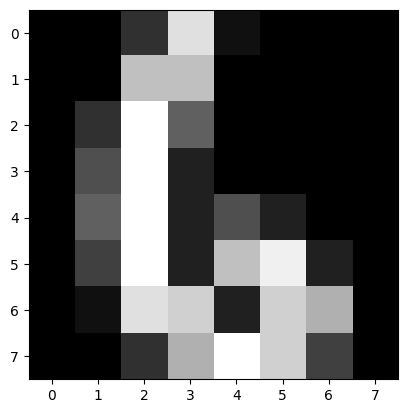

In [534]:
plt.imshow(X_train[0],cmap='gray')

We should get the numbers all between 0 and 1 rather than 0 and 16. To do this let's just divide by 16. But let's build it into the model by setting up a rescaling layer

In [535]:
div16 = tf.keras.layers.Rescaling(
                  scale=1./16)

Sequential Model as usual

In [536]:
model = tf.keras.models.Sequential()

In [537]:
model.add(tf.keras.Input(shape=(8, 8, 1)))

In [538]:
model.add(div16) # add in the rescaling

For the Dense layers, it has to be a "flattened" image. i.e. instead of X_train[0] being 8x8 we want it to be 64. We saw this before with the faces dataset

In [539]:
model.add(tf.keras.layers.Flatten())

Now let's add the hidden layers. I'm going for 2 hidden layers each with 40 units. Why? No real reason why I picked that structure, I just want to see what happens with it

In [540]:
model.add(tf.keras.layers.Dense(40,activation='relu'))

In [541]:
model.add(tf.keras.layers.Dense(40,activation='relu'))

We now need an output layer. Since there are 10 possible categories we need 10 units on the output layer

In [542]:
model.add(tf.keras.layers.Dense(10))

Now compile it. We need to pick the optimiser (just use Adam), the learning rate, the loss function and the metrics that we'll measure (we can put recall and precision in here too and get those values at each epoch)

## Why SparseCategoricalCrossentropy?

categorical_cross_entropy is for one-hot encoded data i.e. as vectors
<img src="onehot.png">

I want to just use numbers to label the things, SparseCategoricalCrossentropy allows me to just use numbers

For example in the above picture red could be 0, blue 1 and green 2

In [543]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

Because I specified the input shape in the first "layer" (Flatten), it can give a summary for me already, I do not have to wait until fitting for a summary

In [544]:
model.summary()

Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_15 (Rescaling)        │ (None, 8, 8, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_14 (Flatten)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 40)             │         2,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 40)             │         1,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 10)             │           410 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,650 (18.16 KB)

 Trainable params: 4,650 (18.16 KB)

 Non-trainable params: 0 (0.00 B)

It needs to learn 4,650 parameters

I could try early stopping etc, but let's just go for 20 epochs

In [545]:
history = model.fit(X_train, y_train, epochs=20, validation_split=0.2)

Epoch 1/20


36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.1685 - loss: 2.2462 - val_accuracy: 0.4688 - val_loss: 2.0010
Epoch 2/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4860 - loss: 1.9239 - val_accuracy: 0.7118 - val_loss: 1.5075
Epoch 3/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7502 - loss: 1.3652 - val_accuracy: 0.8090 - val_loss: 0.9692
Epoch 4/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8709 - loss: 0.8784 - val_accuracy: 0.8160 - val_loss: 0.6669
Epoch 5/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8764 - loss: 0.5896 - val_accuracy: 0.8611 - val_loss: 0.5188
Epoch 6/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9336 - loss: 0.4111 - val_accuracy: 0.8819 - val_loss: 0.4321
Epoch 7/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9371 - loss: 0.3618 - val_accuracy: 0.8889 - val_loss: 0.3722
Epoch 8/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9486 - loss: 0.2668 - val_accuracy: 0.9028 - val_loss: 0.3312
Epo

Looking at the numbers, we may be overfitting things as the training loss accuracy increased but the validation accuracy actually fluctuated a bit more and got worse at the end than previous.

Maybe I should've done early stopping but let's keep going by plotting. I'm copying and pasting this from the regression workbook

Also, I didn't seed any random number generators so you may get a different answer when you run this yourself

In [546]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    try:
        plt.plot(history.history['val_loss'], label='val_loss')
    except:
        None
    #plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Error [MPG]')
    plt.legend()
    plt.grid(True)

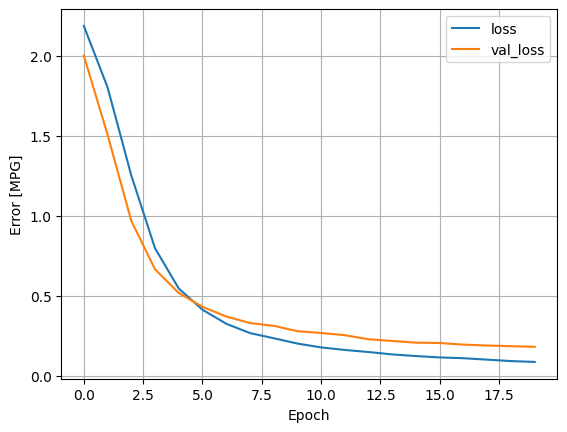

In [547]:
plot_loss(history)

In [548]:
model.evaluate(X_train,y_train,return_dict=True)

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9876 - loss: 0.0784  


{'accuracy': 0.97633957862854, 'loss': 0.10114829242229462}

In [549]:
model.evaluate(X_test,y_test, return_dict=True)

 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 0.0841

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9702 - loss: 0.1074 


{'accuracy': 0.9527778029441833, 'loss': 0.13224205374717712}

In [550]:
X_test.shape

(360, 8, 8)

In [551]:
y_pred = model.predict(X_test)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


In [552]:
y_pred[0]

array([-1.3345041, -3.0691116, -3.4015422, -5.829492 , -0.7003688,
       -1.4558035,  7.6527305, -7.6234093,  1.9689629, -2.381802 ],
      dtype=float32)

In [553]:
y_test[0]

np.int64(6)

In [554]:
np.argmax(y_pred[0])

np.int64(6)

Ok, weird, y_pred seems like just a bunch of numbers. Basically we just want the biggest one of those and that's how we classify it.

It goes back to that "vector" idea I talked about in lecture 1. In my running of it, the biggest number was in position 6 (zero-based index), so the model predicts the thing to be in category 6

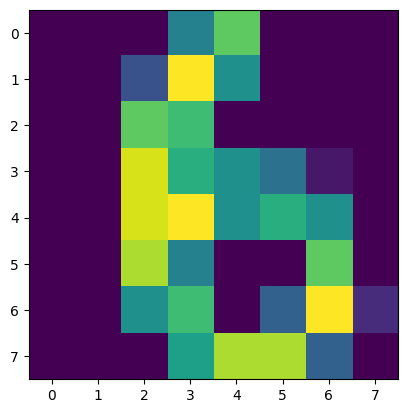

In [555]:
plt.imshow(X_test[0])

That looks like a 6

### Softmax Layer

In class I mentioned using a softmax layer to get probabilities instead at the end. This will look much nicer. I could have included the Softmax layer, made the activation='softmax' in the last layer. However, from Tensorflow documentation:

Note: It is possible to bake the tf.nn.softmax function into the activation function for the last layer of the network. While this can make the model output more directly interpretable, this approach is discouraged as it's impossible to provide an exact and numerically stable loss calculation for all models when using a softmax output. 

So this is why I did not do this. Instead I am going to "add" it on like so

In [556]:
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])

In [557]:
probability_model.summary()

Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_23 (Sequential)      │ (None, 10)             │         4,650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax_8 (Softmax)             │ (None, 10)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,650 (18.16 KB)

 Trainable params: 4,650 (18.16 KB)

 Non-trainable params: 0 (0.00 B)

We don't need to do anymore training, as the model has already learnt all 4,650 parameters. This is a very very simple transfer learning thing but will work well for us now

In [558]:
y_predictions = probability_model.predict(X_test)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


In [559]:
y_predictions[0][6]

np.float32(0.9960601)

The model says with probability 0.993 that the image is a 6. (Technically it's not a probability but I'm not getting into that since it is "almost" a probability)

In [560]:
np.argmax(y_predictions[0])


np.int64(6)

In [561]:
y_test[0]

np.int64(6)

This plotting (code robbed from Google's documentation) will visualise the images

In [562]:
def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)
  #print(predicted_label)
  #print(true_label)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')


In [563]:
class_names = np.arange(0,10)

In [564]:
X_test.shape

(360, 8, 8)

In [565]:
y_test.shape

(360,)

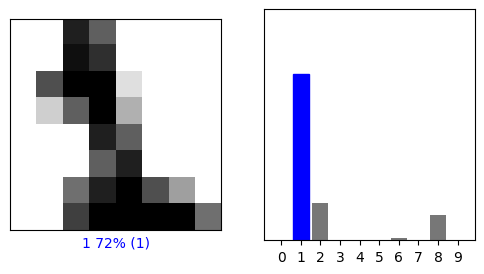

In [566]:
i = 5
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, y_predictions[i], y_test, X_test)
plt.subplot(1,2,2)
plot_value_array(i, y_predictions[i],  y_test)
plt.show()


This plots the image on the left. Under that is the predicted class, then the "probability" that the model came up with, in brackets is the correct class.

The left plot shows a barchart of probabilities.

If everything is written in blue and the plot is in blue, then it was a correct prediction. If in red an incorrect prediction.

Let's now print 30 of them

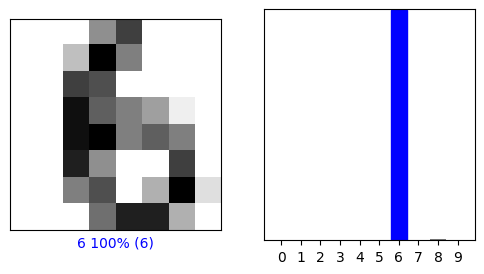

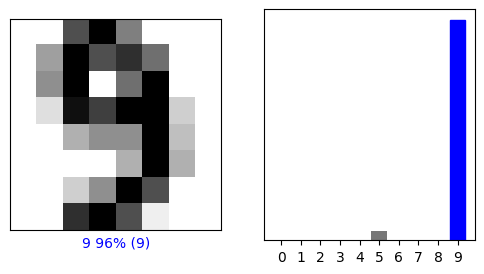

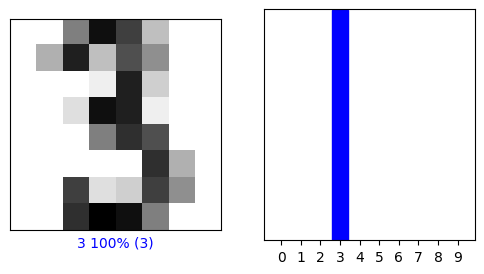

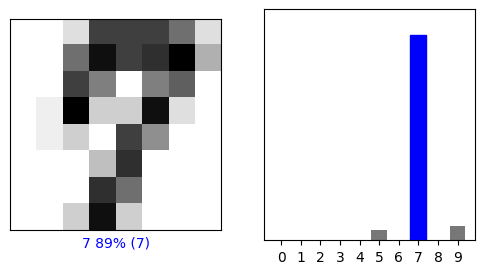

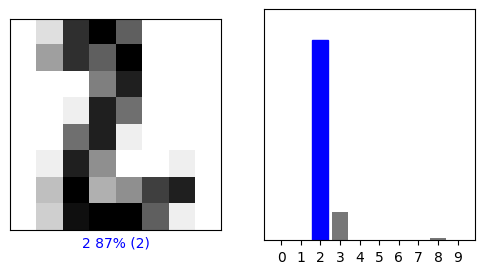

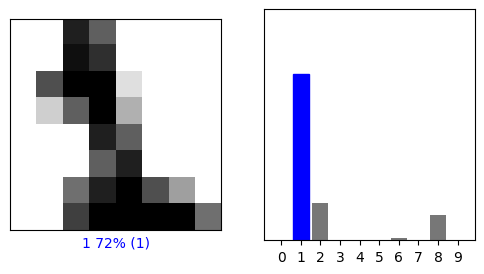

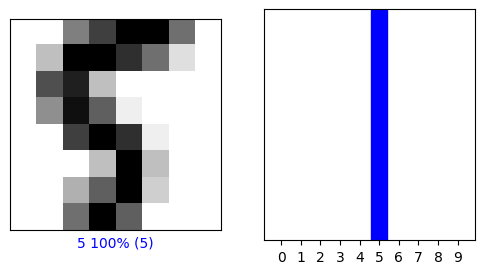

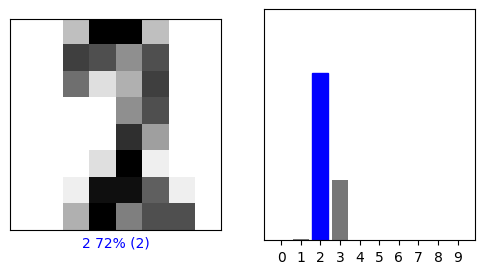

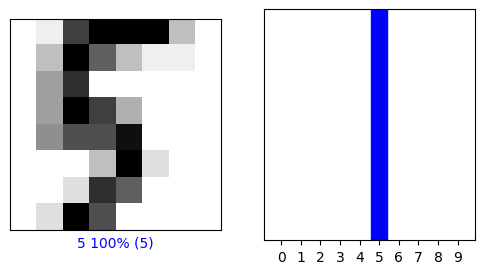

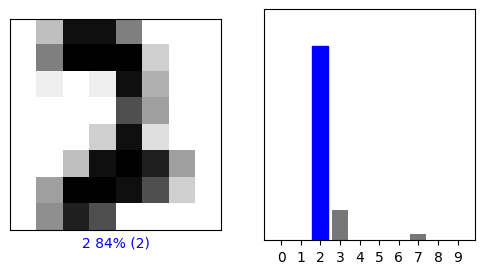

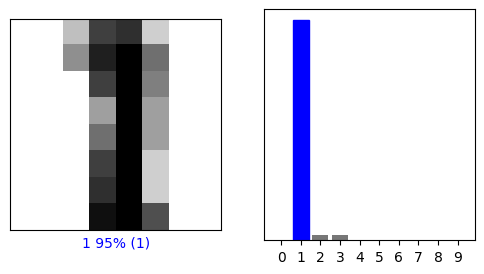

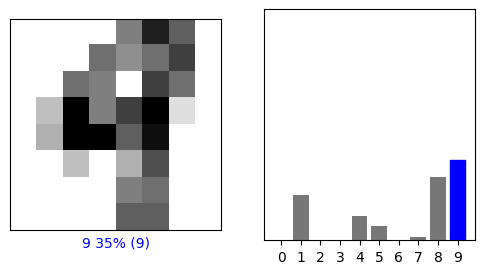

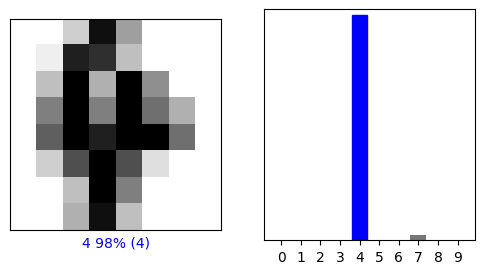

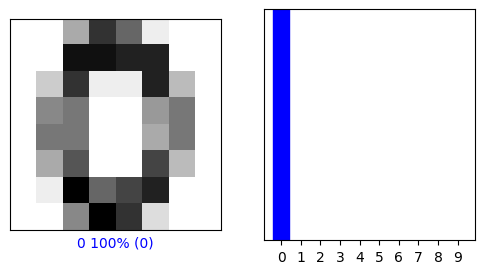

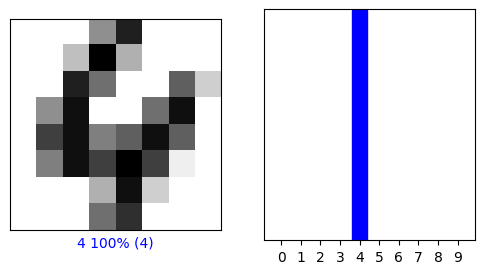

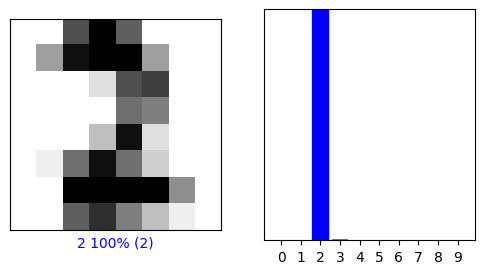

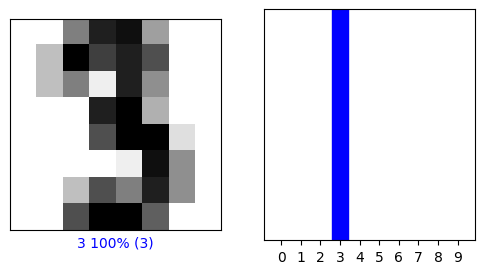

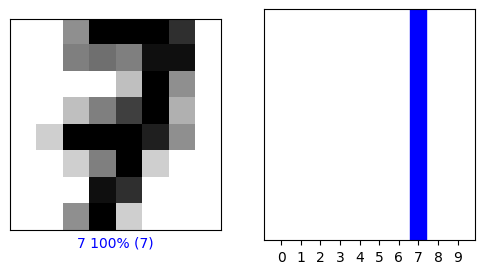

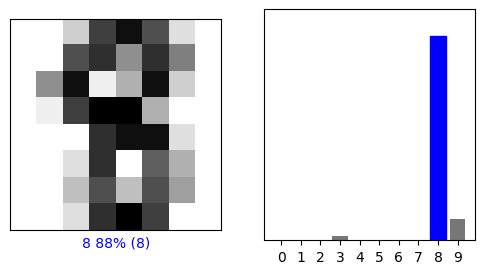

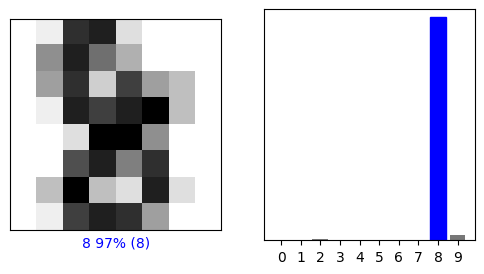

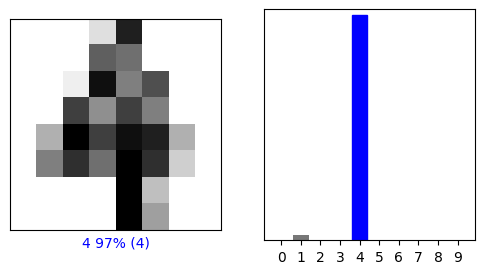

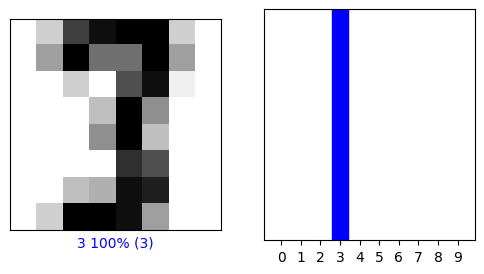

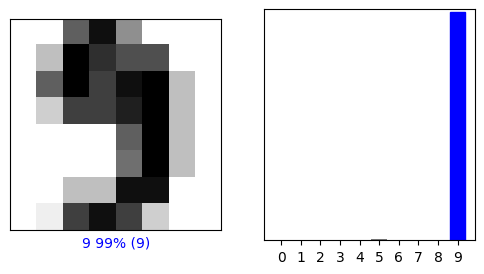

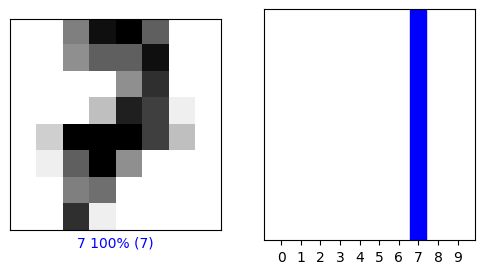

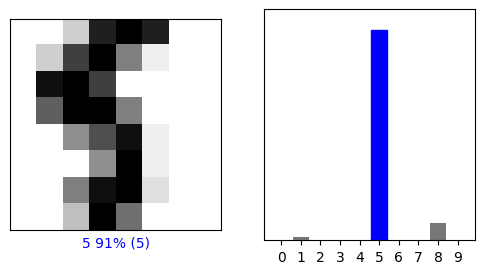

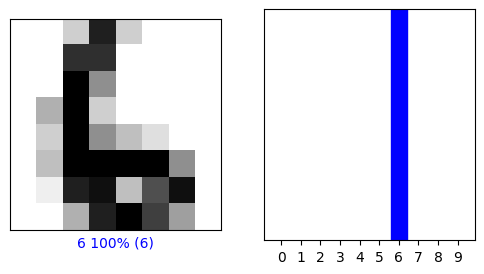

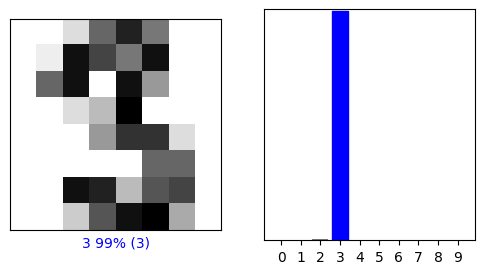

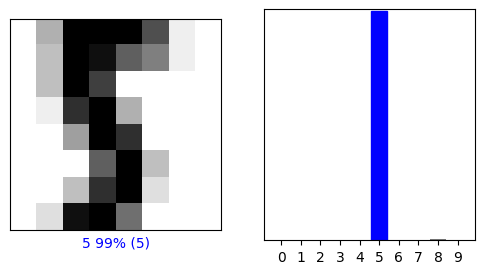

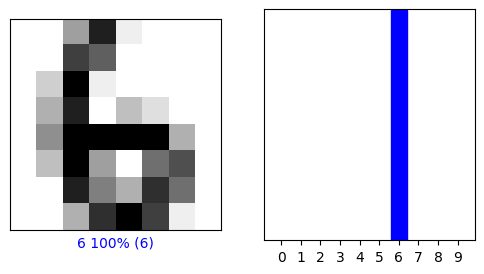

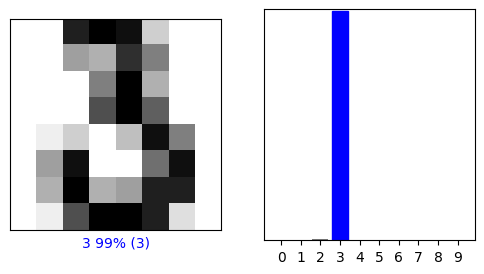

In [567]:
for i in range(0,30):
    plt.figure(figsize=(6,3))
    plt.subplot(1,2,1)
    plot_image(i, y_predictions[i], y_test, X_test)
    plt.subplot(1,2,2)
    plot_value_array(i, y_predictions[i],  y_test)
    plt.show()

Now let's pick some ones I know are incorrect to ensure we see some (maybe 1 of the above were incorrect but all of these following will be)

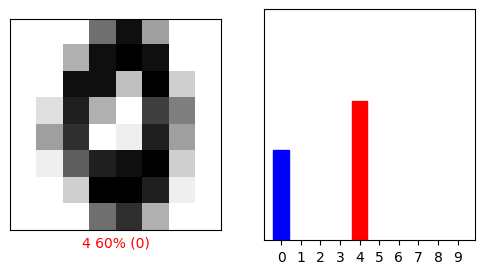

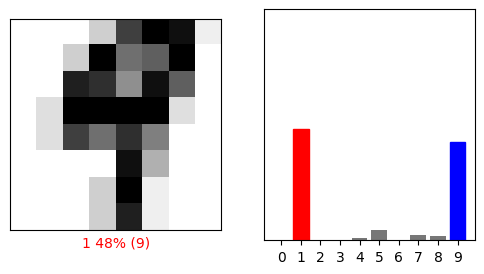

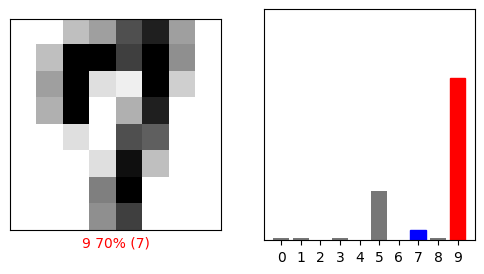

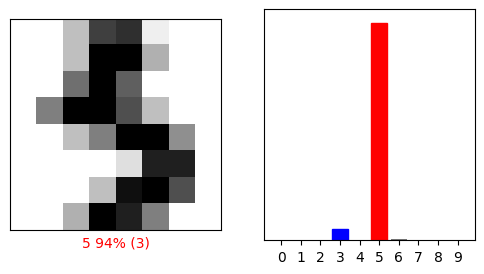

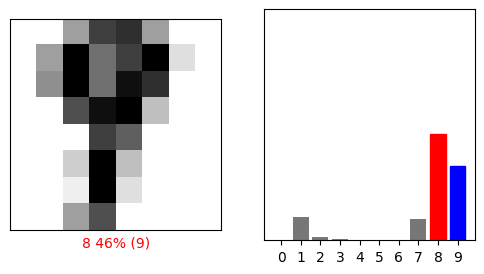

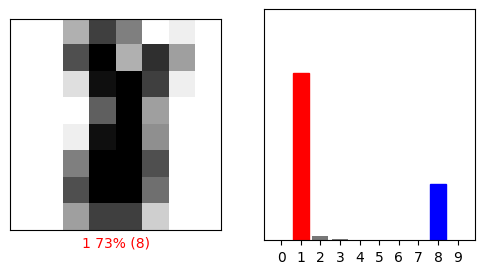

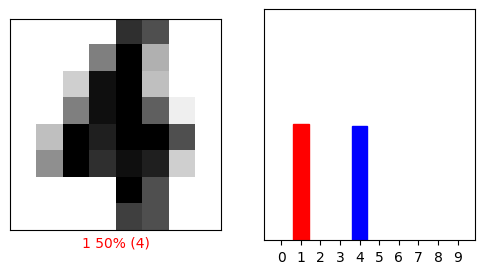

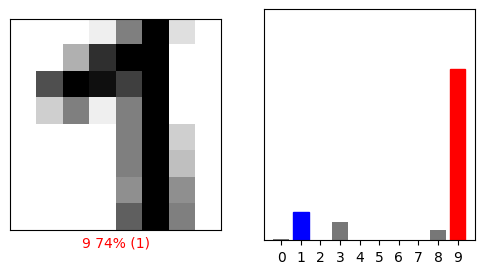

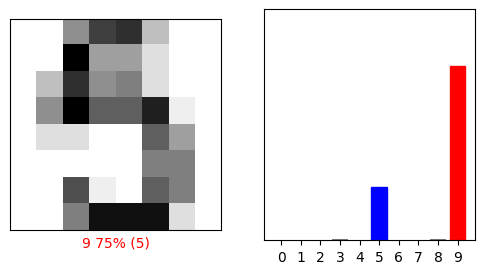

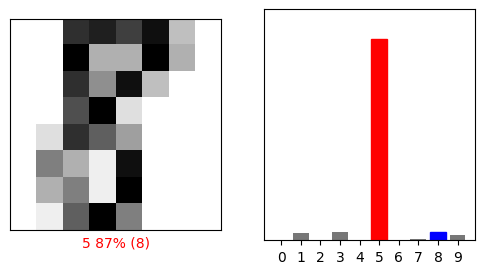

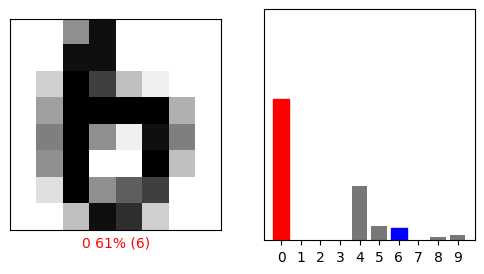

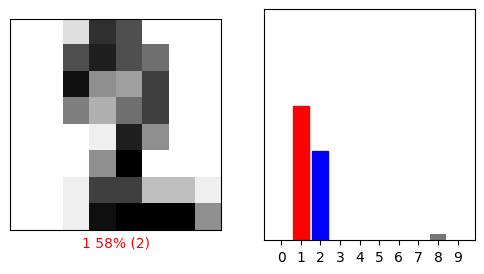

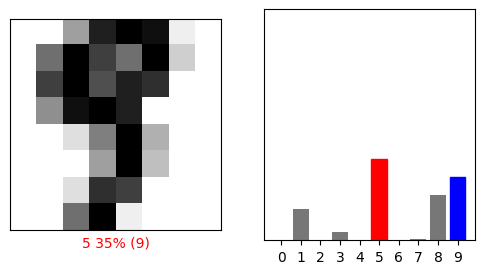

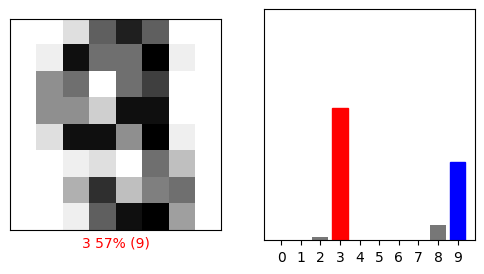

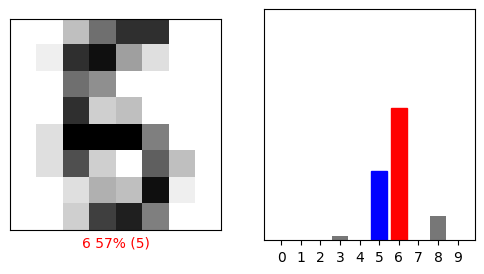

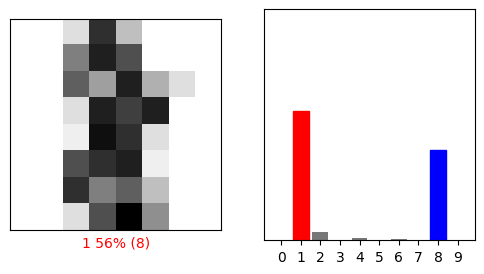

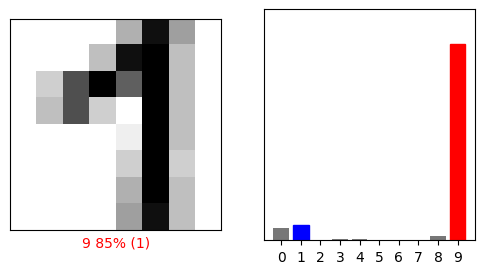

In [568]:
for i in range(0,y_test.shape[0]):
    predicted_label = np.argmax(y_predictions[i])
    true_label = y_test[i]
    if(predicted_label != true_label):
        plt.figure(figsize=(6,3))
        plt.subplot(1,2,1)
        plot_image(i, y_predictions[i], y_test, X_test)
        plt.subplot(1,2,2)
        plot_value_array(i, y_predictions[i],  y_test)
        plt.show()

## New Image DataSet.

This is for you to do, repeat the above with a "better" dataset. Images with 28x28 resolution!

In [569]:
mnist = tf.keras.datasets.mnist

In [570]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [571]:
train_images.shape

(60000, 28, 28)

In [572]:
test_images.shape

(10000, 28, 28)

We're not going to use train_test_split as tf.keras has already divided the images for us

In [573]:
np.max(train_images)

np.uint8(255)

8-bit images too, the values go from 0-255.

(RGB is a problem for CNN, we'll deal with it then)

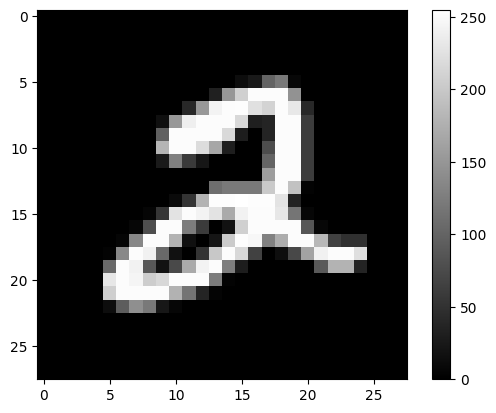

2


In [574]:
plt.figure()
plt.imshow(train_images[5], cmap='gray')
plt.colorbar()
plt.grid(False)
plt.show()
print(train_labels[5])

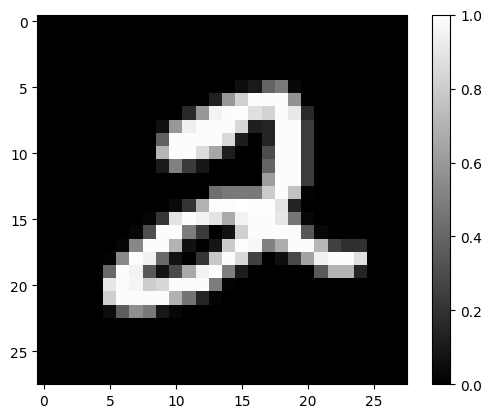

2


In [575]:
plt.figure()
plt.imshow(train_images[5]/255, cmap='gray')
plt.colorbar()
plt.grid(False)
plt.show()
print(train_labels[5])

matplotlib works fine with the values from 0-255 or from 0-1 for grayscale. 

0-1 tends to work better. I am <b>not</b> using StandardScaler, I am just dividing by 255

In [576]:
train_images[5]/255

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.    

We should build this into the model. The below will give us a new layer we can use

change image data so it can be processed

In [577]:
# rescale the images to [0,1]
div255 = tf.keras.layers.Rescaling(scale=1./255)

In [578]:
# use the sequential API to build the model
model2 = tf.keras.models.Sequential()

## build the model

In [579]:
model2.add(tf.keras.Input(shape=(28, 28, 1)))

In [580]:
model2.add(div255) # add in the rescaling

In [581]:
model2.add(tf.keras.layers.Flatten())

In [582]:
model2.add(tf.keras.layers.Dense(40,activation='relu'))

In [583]:
model2.add(tf.keras.layers.Dense(40,activation='relu'))

In [584]:
model2.add(tf.keras.layers.Dense(10))#10 possible categories

Create Model 2. Sequential.

Add the div255 layer, the flatten layer. The flatten layer does not have to have the input size given to it. Just add it with tf.keras.layers.Flatten() and see what happens.

2 hidden layers with 128 units each and the end dense layer. Compile the model and try printing the summary

Do not add softmax now for the reasons stated above. Add it afterwards like I did above.


In [585]:
model2.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [586]:
model2.summary()

Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_16 (Rescaling)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_15 (Flatten)            │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 40)             │        31,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 40)             │         1,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 10)             │           410 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,450 (130.66 KB)

 Trainable params: 33,450 (130.66 KB)

 Non-trainable params: 0 (0.00 B)

In [587]:
history = model2.fit(train_images, train_labels, epochs=20, validation_split=0.2)

Epoch 1/20
  28/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.2403 - loss: 2.1688     

1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8242 - loss: 0.6082 - val_accuracy: 0.9411 - val_loss: 0.2000
Epoch 2/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9479 - loss: 0.1743 - val_accuracy: 0.9542 - val_loss: 0.1532
Epoch 3/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9614 - loss: 0.1310 - val_accuracy: 0.9626 - val_loss: 0.1316
Epoch 4/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9674 - loss: 0.1078 - val_accuracy: 0.9653 - val_loss: 0.1178
Epoch 5/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9736 - loss: 0.0881 - val_accuracy: 0.9672 - val_loss: 0.1129
Epoch 6/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9766 - loss: 0.0750 - val_accuracy: 0.9635 - val_loss: 0.1249
Epoch 7/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9792 - loss: 0.0660 - val_accuracy: 0.9640 - val_loss: 0.1222
Epoch 8/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9824 - loss: 0.0575 - val_accurac

In [588]:
model2.summary() # I have not told it the input shape!

Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_16 (Rescaling)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_15 (Flatten)            │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 40)             │        31,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 40)             │         1,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 10)             │           410 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 100,352 (392.00 KB)

 Trainable params: 33,450 (130.66 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 66,902 (261.34 KB)

model2.summary() gives an error, as you have not yet built the model so it does not know the input shape.

The previous example knew the input shape as we specified it in Flatten. But this is fine, we can get the summary when we're finished

Now fit it, just do 5 epochs, this one will take longer than previous one

In [589]:
history = model2.fit(train_images, train_labels,
          epochs=5, validation_split=0.2
          )

Epoch 1/5
 124/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9974 - loss: 0.0098

1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9953 - loss: 0.0150 - val_accuracy: 0.9691 - val_loss: 0.1563
Epoch 2/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9938 - loss: 0.0173 - val_accuracy: 0.9670 - val_loss: 0.1611
Epoch 3/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9953 - loss: 0.0147 - val_accuracy: 0.9679 - val_loss: 0.1670
Epoch 4/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9951 - loss: 0.0134 - val_accuracy: 0.9653 - val_loss: 0.1847
Epoch 5/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9953 - loss: 0.0136 - val_accuracy: 0.9682 - val_loss: 0.1706


Show the summary

It got the shape from fit so this works ok now

In [590]:
model2.summary() #

Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_16 (Rescaling)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_15 (Flatten)            │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 40)             │        31,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 40)             │         1,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 10)             │           410 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 100,352 (392.00 KB)

 Trainable params: 33,450 (130.66 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 66,902 (261.34 KB)

The summary shows we had to train 118,282 parameters. This stuff is getting trickier

In [591]:
model2.evaluate(test_images,test_labels)

 32/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9727 - loss: 0.1298       

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9613 - loss: 0.1924


[0.16800741851329803, 0.967199981212616]

Should be quite a high accuracy, over 97%

Add the Softmax now

In [592]:
probability_model2 = tf.keras.Sequential([model2, 
                                         tf.keras.layers.Softmax()])

In [593]:
y_pred = probability_model2.predict(test_images)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [594]:
y_pred[0]

array([1.0799673e-14, 6.9945547e-12, 5.4139495e-08, 9.9063880e-07,
       1.0376443e-13, 5.8487731e-20, 6.2596271e-23, 9.9999905e-01,
       2.9327048e-11, 3.6210909e-10], dtype=float32)

In [595]:
np.argmax(y_pred[0])

np.int64(7)

In [596]:
test_labels[0]

np.uint8(7)

Plot them as before

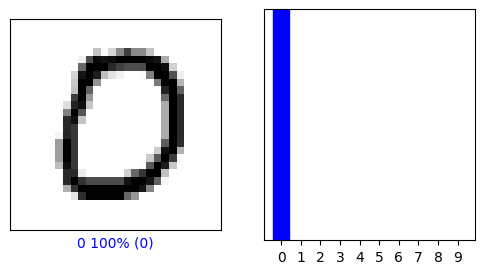

In [ ]:
i = 10
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, y_pred[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, y_pred[i],  test_labels)
plt.show()

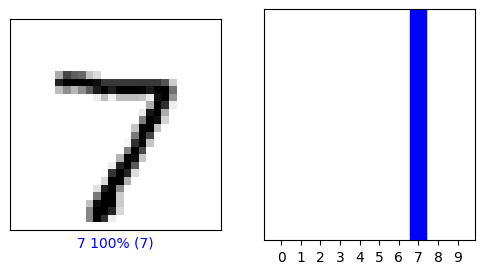

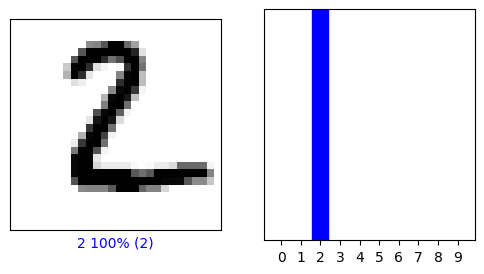

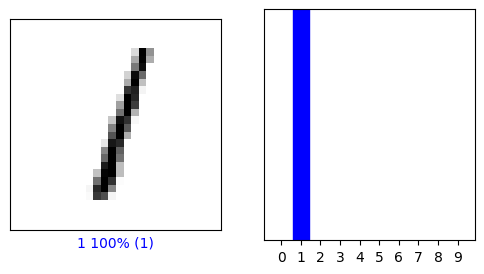

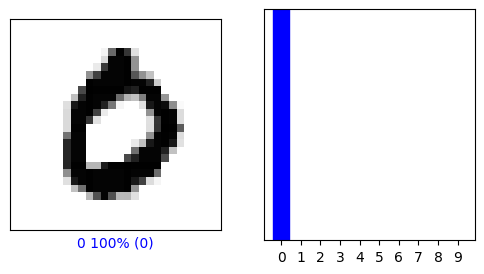

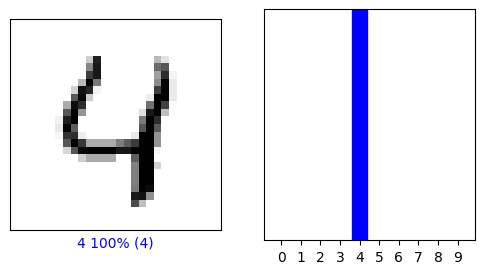

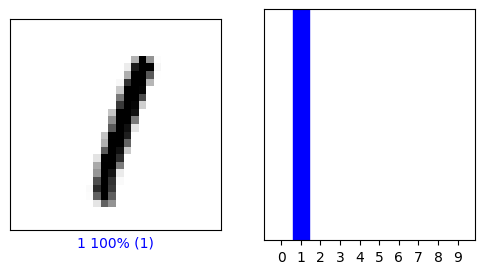

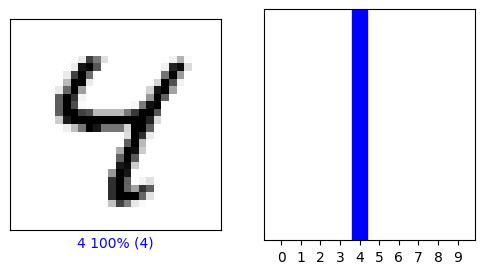

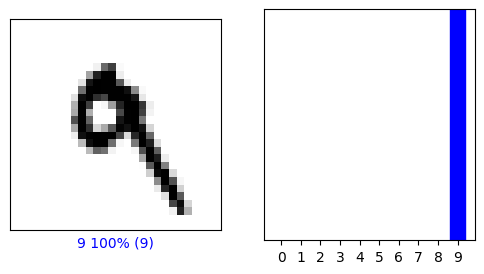

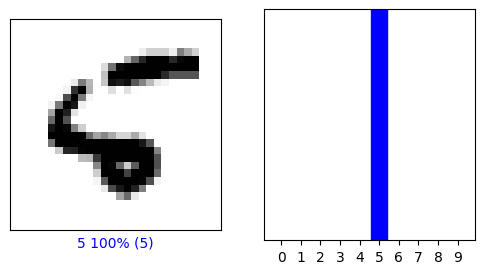

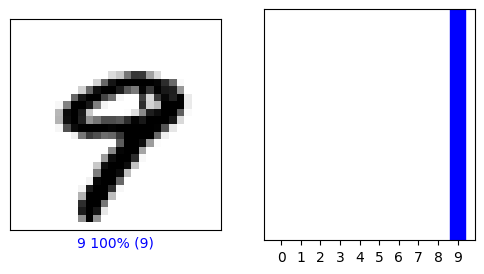

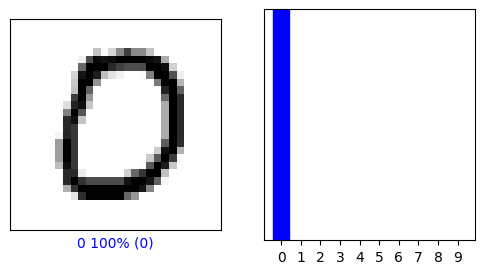

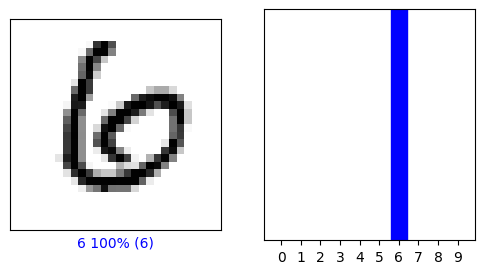

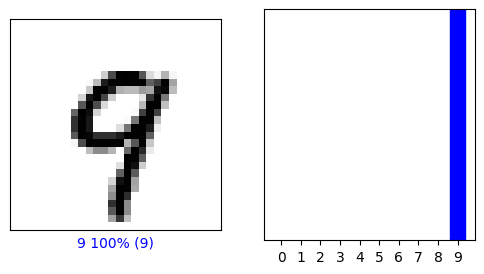

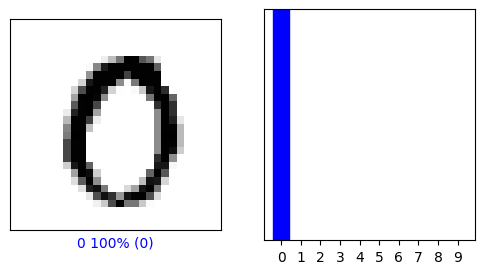

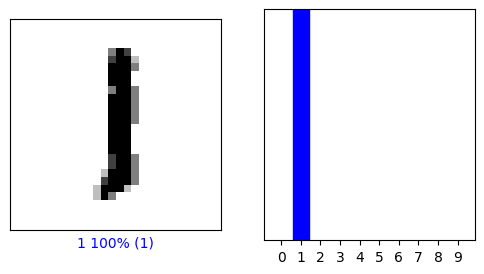

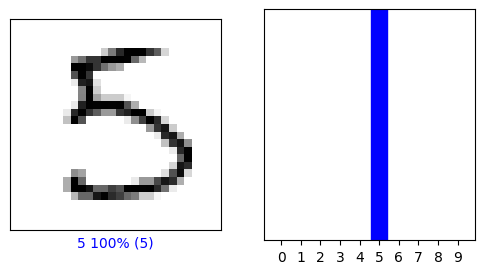

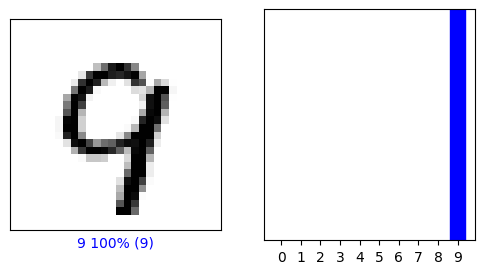

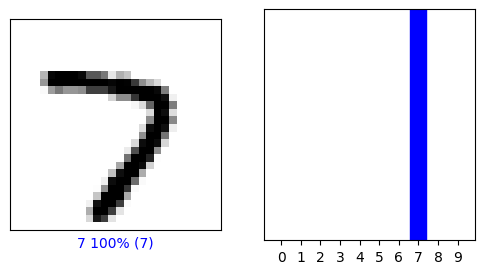

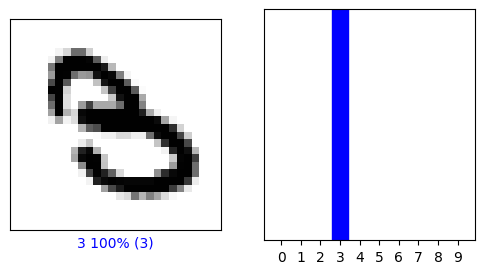

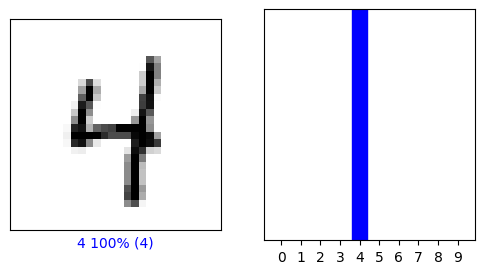

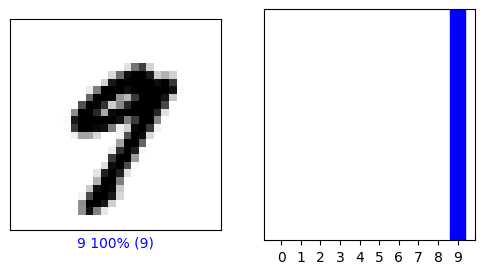

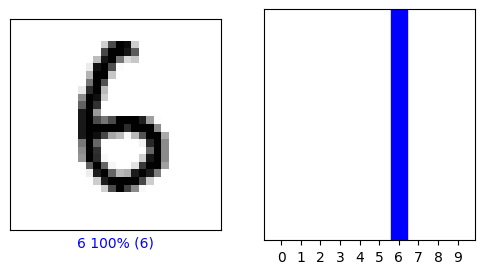

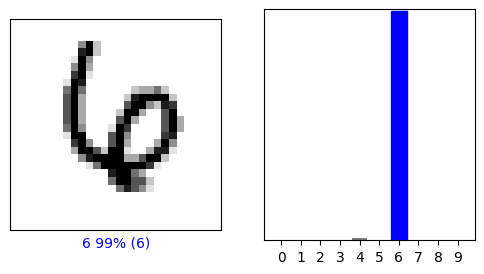

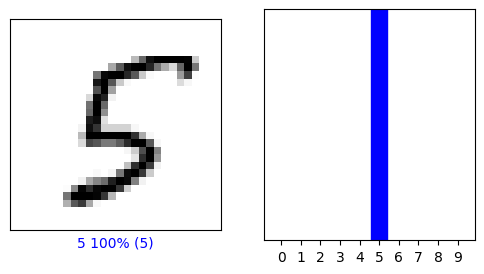

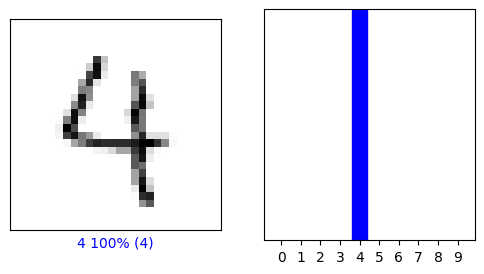

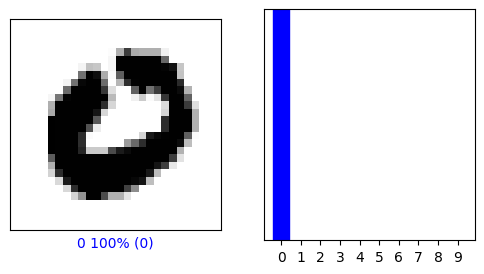

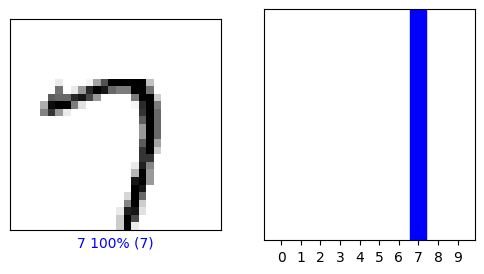

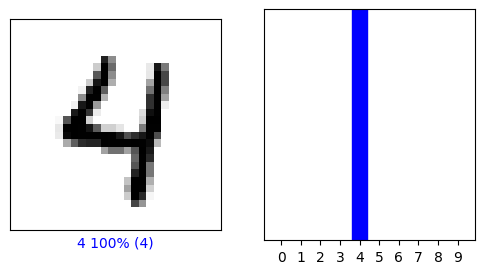

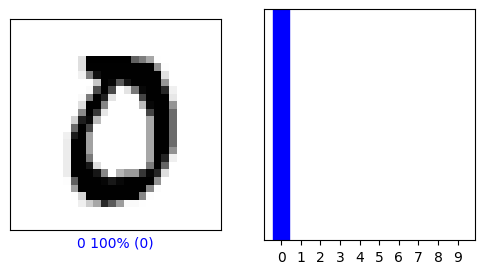

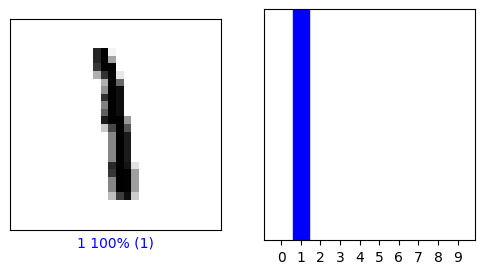

In [634]:

for i in range(0,30):
    plt.figure(figsize=(6,3))
    plt.subplot(1,2,1)
    plot_image(i, y_pred[i], test_labels, test_images)
    plt.subplot(1,2,2)
    plot_value_array(i, y_pred[i],  test_labels)
    plt.show()

## Now using a CNN

This is the optimal image classifier (use this for future reference)

In [597]:
from tensorflow.keras import layers
img_height = img_width = 28

In [598]:
model_cnn = tf.keras.models.Sequential()

In [599]:
model_cnn.add(tf.keras.Input(shape=(img_height, img_width, 1)))

In [600]:
model_cnn.add(layers.Rescaling(1./255))

In [601]:
model_cnn.add(layers.Conv2D(12, 3, padding='same', activation='relu'))

In [602]:
model_cnn.add(layers.MaxPooling2D())

In [603]:
model_cnn.add(layers.Flatten())
model_cnn.add(layers.Dense(10))

In [604]:
model.summary()

Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_15 (Rescaling)        │ (None, 8, 8, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_14 (Flatten)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 40)             │         2,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 40)             │         1,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 10)             │           410 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,952 (54.50 KB)

 Trainable params: 4,650 (18.16 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 9,302 (36.34 KB)

In [605]:
model_cnn.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [606]:
history = model_cnn.fit(train_images, train_labels,
          epochs=10, validation_split=0.2
          )

Epoch 1/10
 445/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7370 - loss: 0.9577

1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8494 - loss: 0.5495 - val_accuracy: 0.9661 - val_loss: 0.1244
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9661 - loss: 0.1189 - val_accuracy: 0.9758 - val_loss: 0.0900
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9763 - loss: 0.0816 - val_accuracy: 0.9782 - val_loss: 0.0792
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9807 - loss: 0.0673 - val_accuracy: 0.9775 - val_loss: 0.0766
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9823 - loss: 0.0586 - val_accuracy: 0.9778 - val_loss: 0.0777
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9855 - loss: 0.0497 - val_accuracy: 0.9792 - val_loss: 0.0722
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9852 - loss: 0.0475 - val_accuracy: 0.9785 - val_loss: 0.0727
Epoch 8/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9886 - loss: 0.0387 - val_accurac

Previously, the fully connected ANN had accuracy: 0.9750 for the training set 

We could get training accuracy up further with more epochs, but that might be overfitting, let's analyse this first though.

In [607]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    try:
        plt.plot(history.history['val_loss'], label='val_loss')
    except:
        None
    plt.xlabel('Epoch')
    plt.ylabel('Error [MPG]')
    plt.legend()
    plt.grid(True)

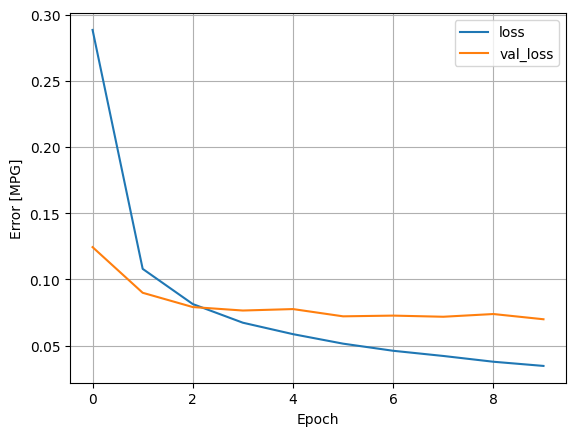

In [608]:
plot_loss(history)

The plot is diverging between val_loss and loss so might be some overfitting here, maybe should have used early stopping or chosen different hyperparameters

In [609]:
model_cnn.evaluate(test_images, test_labels, return_dict=True)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9747 - loss: 0.0796


{'accuracy': 0.9797999858856201, 'loss': 0.06529654562473297}

0.9717 was the score for the previous fully dense. So an improvement alright, but this is an extremely basic CNN, and the images were greyscale, CNN would do much much better with RGB than dense networks

In [610]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

This tends to be more efficient, it loses some data but will have a lot less weights in the end

In [611]:
model_cnn2 = tf.keras.models.Sequential()
model_cnn2.add(tf.keras.Input(shape=(img_height, img_width, 1)))
model_cnn2.add(layers.Rescaling(1./255))
model_cnn2.add(layers.Conv2D(12, 3, padding='same', activation='relu'))
model_cnn2.add(layers.MaxPooling2D())
model_cnn2.add(layers.Flatten())
model_cnn2.add(layers.Dense(10))
model_cnn2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [612]:
model_cnn2.fit(train_images, train_labels, epochs=100, validation_split=0.2, callbacks=[callback])

Epoch 1/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8402 - loss: 0.5940 - val_accuracy: 0.9513 - val_loss: 0.1717
Epoch 2/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9599 - loss: 0.1383 - val_accuracy: 0.9697 - val_loss: 0.1032
Epoch 3/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9755 - loss: 0.0876 - val_accuracy: 0.9770 - val_loss: 0.0860
Epoch 4/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9801 - loss: 0.0700 - val_accuracy: 0.9776 - val_loss: 0.0765
Epoch 5/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9823 - loss: 0.0585 - val_accuracy: 0.9795 - val_loss: 0.0723
Epoch 6/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9842 - loss: 0.0521 - val_accuracy: 0.9785 - val_loss: 0.0738
Epoch 7/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9856 - loss: 0.0463 - val_accuracy: 0.9789 - val_loss: 0.0748
Epoch 8/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9882 - loss: 0

Patience 3 might be too little

In [613]:
model_cnn2.evaluate(test_images,test_labels, return_dict=True)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9732 - loss: 0.0836


{'accuracy': 0.9779000282287598, 'loss': 0.06630820035934448}

## Problem with early stopping and patience

With patience set to 3, we don't actually get the "best" model, the one with the lowest validation loss, we get the model 3 epochs after the best one!

So we can use another callback to save the "best" model if we want. 

`ModelCheckpoint(filepath='best_model.keras', monitor='val_loss', save_best_only=True)`

will do this

In [614]:
callback_earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [615]:
callback_modelcheckpoint = tf.keras.callbacks.ModelCheckpoint(filepath='best_model.keras', monitor='val_loss', save_best_only=True)

In [616]:
model_cnn3 = tf.keras.models.Sequential()
model_cnn3.add(tf.keras.Input(shape=(img_height, img_width, 1)))
model_cnn3.add(layers.Rescaling(1./255))
model_cnn3.add(layers.Conv2D(12, 3, padding='same', activation='relu'))
model_cnn3.add(layers.MaxPooling2D())
model_cnn3.add(layers.Flatten())
model_cnn3.add(layers.Dense(10))
model_cnn3.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [617]:
model_cnn3.fit(train_images, train_labels, epochs=100, validation_split=0.2, callbacks=[callback_earlystop, callback_modelcheckpoint])

Epoch 1/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8543 - loss: 0.5279 - val_accuracy: 0.9643 - val_loss: 0.1285
Epoch 2/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9657 - loss: 0.1222 - val_accuracy: 0.9726 - val_loss: 0.0990
Epoch 3/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9754 - loss: 0.0890 - val_accuracy: 0.9754 - val_loss: 0.0829
Epoch 4/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9808 - loss: 0.0676 - val_accuracy: 0.9775 - val_loss: 0.0785
Epoch 5/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9828 - loss: 0.0572 - val_accuracy: 0.9784 - val_loss: 0.0753
Epoch 6/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9848 - loss: 0.0505 - val_accuracy: 0.9783 - val_loss: 0.0696
Epoch 7/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9860 - loss: 0.0458 - val_accuracy: 0.9773 - val_loss: 0.0758
Epoch 8/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9878 - loss: 0

In [618]:
from keras.models import load_model

In [619]:
saved_model = load_model('best_model.keras')

In [620]:
model_cnn3.evaluate(test_images,test_labels, return_dict=True)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9761 - loss: 0.0776


{'accuracy': 0.9797000288963318, 'loss': 0.06560159474611282}

In [621]:
saved_model.evaluate(test_images,test_labels, return_dict=True)

 85/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9775 - loss: 0.0745

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9780 - loss: 0.0738


{'accuracy': 0.9815999865531921, 'loss': 0.060317713767290115}

In [622]:
model_cnn3.summary()

Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_19 (Rescaling)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 12)     │           120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 12)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_18 (Flatten)            │ (None, 2352)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 10)             │        23,530 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 70,952 (277.16 KB)

 Trainable params: 23,650 (92.38 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 47,302 (184.78 KB)

## Now let's do a "deeper" model"

In [623]:
num_classes = 10

In [624]:
model_cnn4 = tf.keras.models.Sequential([
    tf.keras.Input(shape=(img_height, img_width, 1)),
    layers.Rescaling(1./255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)])

In [625]:
model_cnn4.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [626]:
model_cnn4.summary()

Model: "sequential_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_20 (Rescaling)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 7, 7, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_19 (Flatten)            │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 128)            │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 98,442 (384.54 KB)

 Trainable params: 98,442 (384.54 KB)

 Non-trainable params: 0 (0.00 B)

In [627]:
train_labels

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [628]:
model_cnn4.fit(train_images, train_labels, epochs=100, validation_split=0.2, callbacks=[callback_earlystop, callback_modelcheckpoint])

Epoch 1/100


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.8759 - loss: 0.4002 - val_accuracy: 0.9801 - val_loss: 0.0641
Epoch 2/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.9808 - loss: 0.0603 - val_accuracy: 0.9873 - val_loss: 0.0421
Epoch 3/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.9886 - loss: 0.0364 - val_accuracy: 0.9839 - val_loss: 0.0556
Epoch 4/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.9911 - loss: 0.0284 - val_accuracy: 0.9874 - val_loss: 0.0392
Epoch 5/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.9929 - loss: 0.0215 - val_accuracy: 0.9843 - val_loss: 0.0525
Epoch 6/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.9930 - loss: 0.0208 - val_accuracy: 0.9805 - val_loss: 0.0713
Epoch 7/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 22s 9ms/step - accuracy: 0.9948 - loss: 0.0148 - val_accuracy: 0.9890 - val_loss: 0.0424


In [629]:
saved_model2 = load_model('best_model.keras')

In [630]:
saved_model2.evaluate(test_images,test_labels, return_dict=True)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9858 - loss: 0.0403


{'accuracy': 0.9878000020980835, 'loss': 0.03446030989289284}

In [631]:
model_cnn4.evaluate(test_images,test_labels, return_dict=True)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9884 - loss: 0.0400


{'accuracy': 0.9905999898910522, 'loss': 0.033256638795137405}

Over 99% accuracy on the test set. That's quite good! Although, take note that just because a network is deeper and more complicated does not mean it will perform better. How deep a network is etc is a hyperparameter so it can make the model better or worse like all hyperparameters

You may notice that the number of parameters is less than the dense network done previously

In [632]:
model_cnn4.summary()

Model: "sequential_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_20 (Rescaling)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 7, 7, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_19 (Flatten)            │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 128)            │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 295,328 (1.13 MB)

 Trainable params: 98,442 (384.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 196,886 (769.09 KB)